In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'São Paulo - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_SP.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),São Paulo - Consumo de Cimento (t),São Paulo - Produção de Cimento (t),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,782.111,437.972720,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,789.891,434.363720,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,774.309,433.350868,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,782.071,431.825332,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,841.400,433.287298,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1112.914,515.306495,0.590649,NaN,NaN,NaN,NaN,NaN,NaN
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1028.144,514.812591,0.588569,NaN,NaN,NaN,NaN,NaN,NaN
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,996.449,514.856452,0.585196,NaN,NaN,NaN,NaN,NaN,NaN
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1024.272,515.215930,0.581094,NaN,NaN,NaN,NaN,NaN,NaN


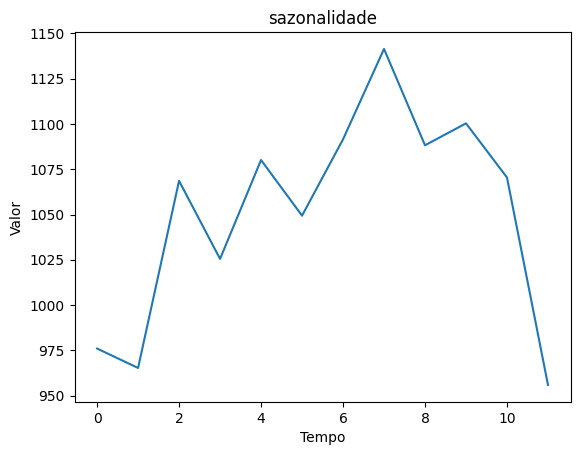

,sazonalidade
sazonalidade,
0,975.978500
1,965.247214
2,1068.600571
3,1025.485071
4,1080.116643
5,1049.376857
6,1091.523500
7,1141.470000
8,1088.254643


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),São Paulo - Produção de Cimento (t),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,sazonalidade,São Paulo - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,437.972720,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723,975.978500,782.111
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,434.363720,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838,965.247214,789.891
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,433.350868,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953,1068.600571,774.309
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,431.825332,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068,1025.485071,782.071
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,433.287298,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183,1080.116643,841.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,515.306495,0.590649,NaN,NaN,NaN,NaN,NaN,NaN,1141.470000,1112.914
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,514.812591,0.588569,NaN,NaN,NaN,NaN,NaN,NaN,1088.254643,1028.144
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,514.856452,0.585196,NaN,NaN,NaN,NaN,NaN,NaN,1100.352857,996.449
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,515.215930,0.581094,NaN,NaN,NaN,NaN,NaN,NaN,1070.447857,1024.272


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      656.269
1      745.154
2      788.618
3      790.169
4      791.663
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: São Paulo - Consumo de Cimento (t), Length: 240, dtype: float64

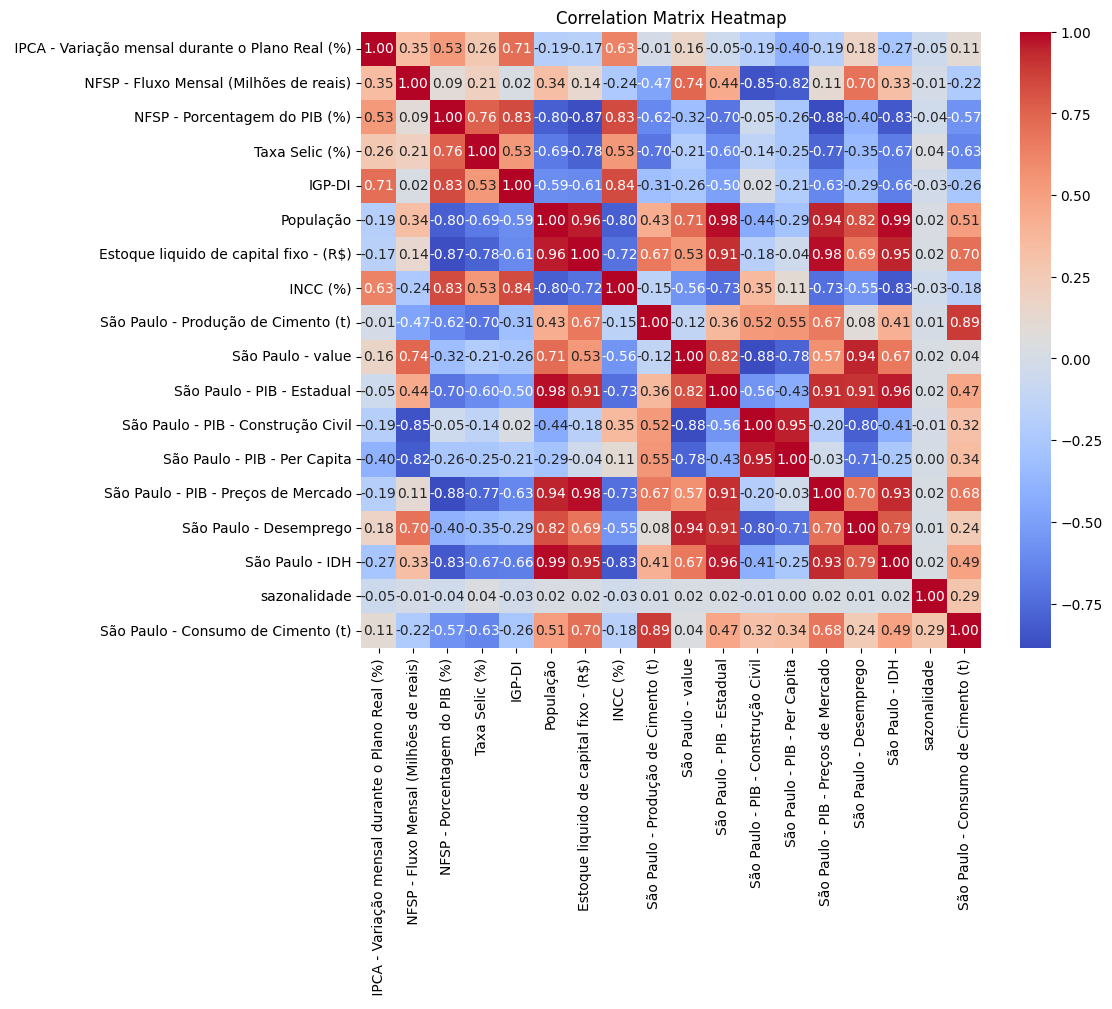

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,IPCA - Variação mensal durante o Plano Real (%),2.742285e+03
1,NFSP - Fluxo Mensal (Milhões de reais),2.507184e+02
2,NFSP - Porcentagem do PIB (%),3.482703e+02
3,Taxa Selic (%),5.538496e+01
4,IGP-DI,3.394585e+02
5,População,4.870406e+06
6,Estoque liquido de capital fixo - (R$),3.016229e+07
7,INCC (%),1.202657e+03
8,São Paulo - Produção de Cimento (t),1.353159e+04
9,São Paulo - value,3.960443e+04


In [39]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 1


,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),São Paulo - Produção de Cimento (t),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - Desemprego,São Paulo - IDH,sazonalidade
0,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,437.972720,0.314974,1.034903e+09,4.730940e+07,23.895559,8.310335,0.812723,975.978500
1,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,434.363720,0.317328,1.036092e+09,4.732994e+07,23.901472,8.304194,0.812838,965.247214
2,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,433.350868,0.319840,1.037280e+09,4.735047e+07,23.907385,8.298053,0.812953,1068.600571
3,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,431.825332,0.322104,1.038469e+09,4.737101e+07,23.913298,8.291912,0.813068,1025.485071
4,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,433.287298,0.324320,1.039658e+09,4.739155e+07,23.919210,8.285771,0.813183,1080.116643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,469.950179,0.406105,1.212786e+09,4.630491e+07,23.905701,11.389052,0.822951,1141.470000
176,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,466.649191,0.407342,1.212582e+09,4.630199e+07,23.904983,11.375100,0.822893,1088.254643
177,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,466.825742,0.408466,1.212378e+09,4.629907e+07,23.904264,11.361149,0.822835,1100.352857
178,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,465.087743,0.409644,1.212174e+09,4.629615e+07,23.903545,11.347197,0.822777,1070.447857


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),São Paulo - Produção de Cimento (t),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - Desemprego,São Paulo - IDH
0,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.519153,-1.162669,-1.662899,-0.566065,-1.650832,-0.738701,-2.201422
1,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.549917,-1.088907,-1.643227,-0.540163,-1.584330,-0.742580,-2.163341
2,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.558550,-1.010192,-1.623554,-0.514262,-1.517828,-0.746458,-2.125260
3,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.571554,-0.939229,-1.603882,-0.488360,-1.451326,-0.750337,-2.087179
4,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.559092,-0.869801,-1.584210,-0.462458,-1.384823,-0.754215,-2.049098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,-1.246570,1.693135,1.280801,-1.832990,-1.536760,1.205700,1.181642
176,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,-1.274708,1.731898,1.277427,-1.836676,-1.544844,1.196888,1.162489
177,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,-1.273203,1.767120,1.274052,-1.840362,-1.552928,1.188077,1.143335
178,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,-1.288018,1.804031,1.270678,-1.844049,-1.561012,1.179266,1.124181


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),São Paulo - Produção de Cimento (t),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - Desemprego,São Paulo - IDH
0,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.519153,-1.162669,-1.662899,-0.566065,-1.650832,-0.738701,-2.201422
1,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.549917,-1.088907,-1.643227,-0.540163,-1.584330,-0.742580,-2.163341
2,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.558550,-1.010192,-1.623554,-0.514262,-1.517828,-0.746458,-2.125260
3,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.571554,-0.939229,-1.603882,-0.488360,-1.451326,-0.750337,-2.087179
4,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.559092,-0.869801,-1.584210,-0.462458,-1.384823,-0.754215,-2.049098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,-0.950957,1.306111,1.294809,-1.710272,-1.425614,1.369417,1.449448
164,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,-0.978232,1.340306,1.296731,-1.729655,-1.436526,1.349010,1.422702
165,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,-1.005176,1.368763,1.298654,-1.749038,-1.447437,1.328603,1.395956
166,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,-1.031429,1.397804,1.300576,-1.768421,-1.458349,1.308195,1.369211


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      656.269
1      745.154
2      788.618
3      790.169
4      791.663
        ...   
163    913.329
164    849.262
165    897.883
166    860.059
167    771.417
Name: São Paulo - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 14)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),São Paulo - Produção de Cimento (t),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - Desemprego,São Paulo - IDH
132,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,0.975323,1.286596,1.033242,-0.509374,-0.460047,1.222593,0.713067
133,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,0.937251,1.335512,1.045767,-0.557827,-0.507310,1.246268,0.705106
134,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,0.871910,1.366241,1.058292,-0.606280,-0.554572,1.269944,0.697145
135,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,0.804706,1.395265,1.070817,-0.654732,-0.601835,1.293619,0.689184
136,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,0.736005,1.426725,1.083342,-0.703185,-0.649097,1.317295,0.681223
137,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,0.665540,1.458118,1.095867,-0.751638,-0.696360,1.340970,0.673262
138,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,0.593536,1.492514,1.108392,-0.800091,-0.743622,1.364646,0.665302
139,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,0.519616,1.510813,1.120917,-0.848544,-0.790885,1.388321,0.657341
140,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,0.444221,1.515905,1.133443,-0.896997,-0.838147,1.411997,0.649380
141,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,0.367730,1.512605,1.145968,-0.945450,-0.885410,1.435672,0.641419


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 14)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[512346465, 3084784115, 2413457759, 2155442509, 2539218127, 514312081, 299977474, 4022512009, 2793588361, 2709395094]


Step: 0 ___________________________________________
val_loss: 39620.1640625
winner_seed: 512346465


Step: 1 ___________________________________________
val_loss: 15749.2939453125
winner_seed: 3084784115


Step: 2 ___________________________________________
val_loss: 46150.29296875


Step: 3 ___________________________________________
val_loss: 10107.1591796875
winner_seed: 2155442509


Step: 4 ___________________________________________
val_loss: 21087092736.0


Step: 5 ___________________________________________
val_loss: 44779.35546875


Step: 6 ___________________________________________
val_loss: 43771.65234375


Step: 7 ___________________________________________
val_loss: 49287.015625


Step: 8 ___________________________________________
val_loss: 9168.0986328125
winner_seed: 2793588361


Step: 9 ___________________________________________
val_loss: 45226.57421

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 117ms/step - loss: 899590.6875 - val_loss: 52414.4688
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 29979.4805 - val_loss: 87604.8125
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 29448.3770 - val_loss: 66745.5078
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 27948.1133 - val_loss: 72647.1641
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 27184.4434 - val_loss: 58490.0391
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 29305.8164 - val_loss: 61663.7422
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 28841.5762 - val_loss: 64323.9297
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 26191.6602 - val_loss: 61068.8555
Epoch 9/10000
4/4 [==============================] - 0s 10ms/step - loss: 25984.5312 - val_loss: 74446.2031
Epoch 10/10000
4/4 [==========

4/4 [==============================] - 0s 11ms/step - loss: 11243.7578 - val_loss: 9831.3916
Epoch 77/10000
4/4 [==============================] - 0s 11ms/step - loss: 12207.0801 - val_loss: 9695.3027
Epoch 78/10000
4/4 [==============================] - 0s 12ms/step - loss: 11298.6094 - val_loss: 11457.4580
Epoch 79/10000
4/4 [==============================] - 0s 12ms/step - loss: 11480.2764 - val_loss: 10563.6152
Epoch 80/10000
4/4 [==============================] - 0s 12ms/step - loss: 10803.1289 - val_loss: 10286.4639
Epoch 81/10000
4/4 [==============================] - 0s 11ms/step - loss: 12182.1826 - val_loss: 15396.6035
Epoch 82/10000
4/4 [==============================] - 0s 12ms/step - loss: 12486.9570 - val_loss: 13221.6582
Epoch 83/10000
4/4 [==============================] - 0s 11ms/step - loss: 11022.8779 - val_loss: 11767.1006
Epoch 84/10000
4/4 [==============================] - 0s 11ms/step - loss: 11722.7412 - val_loss: 11825.7539
Epoch 85/10000
4/4 [================

4/4 [==============================] - 0s 12ms/step - loss: 10958.8730 - val_loss: 9611.6787
Epoch 152/10000
4/4 [==============================] - 0s 12ms/step - loss: 10163.4355 - val_loss: 9917.2949
Epoch 153/10000
4/4 [==============================] - 0s 11ms/step - loss: 9838.6074 - val_loss: 9745.1973
Epoch 154/10000
4/4 [==============================] - 0s 11ms/step - loss: 10077.2451 - val_loss: 10774.2969
Epoch 155/10000
4/4 [==============================] - 0s 11ms/step - loss: 10540.9180 - val_loss: 9215.4688
Epoch 156/10000
4/4 [==============================] - 0s 11ms/step - loss: 10723.5967 - val_loss: 9283.6846
Epoch 157/10000
4/4 [==============================] - 0s 10ms/step - loss: 11399.5479 - val_loss: 9417.6484
Epoch 158/10000
4/4 [==============================] - 0s 11ms/step - loss: 11764.4160 - val_loss: 9299.0098
Epoch 159/10000
4/4 [==============================] - 0s 11ms/step - loss: 10124.7900 - val_loss: 9180.5225
Epoch 160/10000
4/4 [==============

4/4 [==============================] - 0s 12ms/step - loss: 12206.2725 - val_loss: 9463.5029
Epoch 227/10000
4/4 [==============================] - 0s 12ms/step - loss: 10857.5918 - val_loss: 9208.3721
Epoch 228/10000
4/4 [==============================] - 0s 12ms/step - loss: 10137.4053 - val_loss: 9267.8232
Epoch 229/10000
4/4 [==============================] - 0s 12ms/step - loss: 9949.3701 - val_loss: 9671.5020
Epoch 230/10000
4/4 [==============================] - 0s 10ms/step - loss: 10384.5986 - val_loss: 9312.3877
Epoch 231/10000
4/4 [==============================] - 0s 11ms/step - loss: 10701.5020 - val_loss: 9568.3115
Epoch 232/10000
4/4 [==============================] - 0s 11ms/step - loss: 11394.2637 - val_loss: 10137.3242
Epoch 233/10000
4/4 [==============================] - 0s 12ms/step - loss: 9581.9473 - val_loss: 9792.6074
Epoch 234/10000
4/4 [==============================] - 0s 11ms/step - loss: 10816.1543 - val_loss: 10085.3877
Epoch 235/10000
4/4 [==============

4/4 [==============================] - 0s 11ms/step - loss: 9165.0879 - val_loss: 11608.6445
Epoch 302/10000
4/4 [==============================] - 0s 12ms/step - loss: 8965.0752 - val_loss: 11937.0234
Epoch 303/10000
4/4 [==============================] - 0s 11ms/step - loss: 9056.8525 - val_loss: 12237.1621
Epoch 304/10000
4/4 [==============================] - 0s 11ms/step - loss: 9333.8359 - val_loss: 11198.2227
Epoch 305/10000
4/4 [==============================] - 0s 12ms/step - loss: 8467.7012 - val_loss: 10829.4844
Epoch 306/10000
4/4 [==============================] - 0s 12ms/step - loss: 8799.6943 - val_loss: 11390.6455
Epoch 307/10000
4/4 [==============================] - 0s 11ms/step - loss: 9050.9180 - val_loss: 11161.7930
Epoch 308/10000
4/4 [==============================] - 0s 12ms/step - loss: 9069.0889 - val_loss: 11561.0195
Epoch 309/10000
4/4 [==============================] - 0s 12ms/step - loss: 8566.0088 - val_loss: 12378.2178
Epoch 310/10000
4/4 [==============

4/4 [==============================] - 0s 10ms/step - loss: 10130.0615 - val_loss: 10016.6602
Epoch 377/10000
4/4 [==============================] - 0s 12ms/step - loss: 9819.4980 - val_loss: 9906.7734
Epoch 378/10000
4/4 [==============================] - 0s 12ms/step - loss: 9504.5010 - val_loss: 9452.9834
Epoch 379/10000
4/4 [==============================] - 0s 12ms/step - loss: 10205.1211 - val_loss: 10348.5166
Epoch 380/10000
4/4 [==============================] - 0s 11ms/step - loss: 9715.6104 - val_loss: 9895.0342
Epoch 381/10000
4/4 [==============================] - 0s 11ms/step - loss: 9532.5225 - val_loss: 9596.8535
Epoch 382/10000
4/4 [==============================] - 0s 11ms/step - loss: 9576.9248 - val_loss: 9743.8125
Epoch 383/10000
4/4 [==============================] - 0s 11ms/step - loss: 9824.1514 - val_loss: 10330.4785
Epoch 384/10000
4/4 [==============================] - 0s 11ms/step - loss: 9759.5762 - val_loss: 10544.1914
Epoch 385/10000
4/4 [=================

4/4 [==============================] - 0s 13ms/step - loss: 9601.9209 - val_loss: 9767.5654
Epoch 452/10000
4/4 [==============================] - 0s 13ms/step - loss: 9803.9395 - val_loss: 9722.3799
Epoch 453/10000
4/4 [==============================] - 0s 11ms/step - loss: 10878.9316 - val_loss: 9370.3965
Epoch 454/10000
4/4 [==============================] - 0s 11ms/step - loss: 9823.1680 - val_loss: 9402.9785
Epoch 455/10000
4/4 [==============================] - 0s 11ms/step - loss: 9569.4307 - val_loss: 9194.6279
Epoch 456/10000
4/4 [==============================] - 0s 11ms/step - loss: 10301.2051 - val_loss: 16282.0215
Epoch 457/10000
4/4 [==============================] - 0s 12ms/step - loss: 10253.1309 - val_loss: 13001.5127
Epoch 458/10000
4/4 [==============================] - 0s 11ms/step - loss: 12055.2686 - val_loss: 10849.0000
Epoch 459/10000
4/4 [==============================] - 0s 12ms/step - loss: 11961.2480 - val_loss: 10613.4307
Epoch 460/10000
4/4 [==============

Epoch 526/10000
4/4 [==============================] - 0s 11ms/step - loss: 9782.6074 - val_loss: 9888.6934
Epoch 527/10000
4/4 [==============================] - 0s 12ms/step - loss: 10426.0410 - val_loss: 9860.9355
Epoch 528/10000
4/4 [==============================] - 0s 11ms/step - loss: 10029.2461 - val_loss: 10120.8223
Epoch 529/10000
4/4 [==============================] - 0s 13ms/step - loss: 9660.0830 - val_loss: 9500.0166
Epoch 530/10000
4/4 [==============================] - 0s 13ms/step - loss: 9774.6484 - val_loss: 9347.4619
Epoch 531/10000
4/4 [==============================] - 0s 11ms/step - loss: 10034.9287 - val_loss: 9483.1113
Epoch 532/10000
4/4 [==============================] - 0s 12ms/step - loss: 9559.4102 - val_loss: 9262.4336
Epoch 533/10000
4/4 [==============================] - 0s 12ms/step - loss: 9499.6758 - val_loss: 9558.6641
Epoch 534/10000
4/4 [==============================] - 0s 11ms/step - loss: 9541.7305 - val_loss: 9773.7910
Epoch 535/10000
4/4 [===

4/4 [==============================] - 0s 12ms/step - loss: 10861.1045 - val_loss: 10535.6602
Epoch 601/10000
4/4 [==============================] - 0s 11ms/step - loss: 11342.2197 - val_loss: 10735.4385
Epoch 602/10000
4/4 [==============================] - 0s 12ms/step - loss: 10449.0322 - val_loss: 10577.1963
Epoch 603/10000
4/4 [==============================] - 0s 11ms/step - loss: 10970.9785 - val_loss: 10475.8438
Epoch 604/10000
4/4 [==============================] - 0s 11ms/step - loss: 10860.1484 - val_loss: 10541.0625
Epoch 605/10000
4/4 [==============================] - 0s 12ms/step - loss: 10433.7275 - val_loss: 10406.8594
Epoch 606/10000
4/4 [==============================] - 0s 11ms/step - loss: 9652.6172 - val_loss: 10526.7695
Epoch 607/10000
4/4 [==============================] - 0s 12ms/step - loss: 10848.7666 - val_loss: 10503.2061
Epoch 608/10000
4/4 [==============================] - 0s 11ms/step - loss: 10281.6260 - val_loss: 10774.6621
Epoch 609/10000
4/4 [======

Epoch 675/10000
4/4 [==============================] - 0s 12ms/step - loss: 10833.7510 - val_loss: 16268.1689
Epoch 676/10000
4/4 [==============================] - 0s 11ms/step - loss: 10416.3691 - val_loss: 15935.4971
Epoch 677/10000
4/4 [==============================] - 0s 12ms/step - loss: 11576.9072 - val_loss: 24170.8398
Epoch 678/10000
4/4 [==============================] - 0s 12ms/step - loss: 10852.3066 - val_loss: 20225.1777
Epoch 679/10000
4/4 [==============================] - 0s 12ms/step - loss: 10129.3311 - val_loss: 20083.3184
Epoch 680/10000
4/4 [==============================] - 0s 11ms/step - loss: 10999.5469 - val_loss: 17846.0996
Epoch 681/10000
4/4 [==============================] - 0s 13ms/step - loss: 10415.9805 - val_loss: 18531.7969
Epoch 682/10000
4/4 [==============================] - 0s 12ms/step - loss: 11095.5801 - val_loss: 24647.8125
Epoch 683/10000
4/4 [==============================] - 0s 12ms/step - loss: 10264.1992 - val_loss: 24262.3555
Epoch 684/

4/4 [==============================] - 0s 11ms/step - loss: 10840.7471 - val_loss: 26843.2617
Epoch 750/10000
4/4 [==============================] - 0s 12ms/step - loss: 11529.5088 - val_loss: 29088.3691
Epoch 751/10000
4/4 [==============================] - 0s 12ms/step - loss: 12383.0459 - val_loss: 27591.7539
Epoch 752/10000
4/4 [==============================] - 0s 13ms/step - loss: 12491.9277 - val_loss: 29118.4727
Epoch 753/10000
4/4 [==============================] - 0s 13ms/step - loss: 11293.0859 - val_loss: 29502.9648
Epoch 754/10000
4/4 [==============================] - 0s 13ms/step - loss: 11508.7686 - val_loss: 28872.1914
Epoch 755/10000
4/4 [==============================] - 0s 13ms/step - loss: 11078.0889 - val_loss: 28072.7344
Epoch 756/10000
4/4 [==============================] - 0s 11ms/step - loss: 11129.4238 - val_loss: 27899.8223
Epoch 757/10000
4/4 [==============================] - 0s 12ms/step - loss: 11943.6533 - val_loss: 26748.4316
Epoch 758/10000
4/4 [=====

4/4 [==============================] - 0s 11ms/step - loss: 10690.0146 - val_loss: 33233.0195
Epoch 824/10000
4/4 [==============================] - 0s 11ms/step - loss: 11746.6055 - val_loss: 34890.5078
Epoch 825/10000
4/4 [==============================] - 0s 11ms/step - loss: 11189.5547 - val_loss: 37751.2461
Epoch 826/10000
4/4 [==============================] - 0s 11ms/step - loss: 10890.7656 - val_loss: 35835.0234
Epoch 827/10000
4/4 [==============================] - 0s 13ms/step - loss: 10824.0615 - val_loss: 38253.0820
Epoch 828/10000
4/4 [==============================] - 0s 11ms/step - loss: 11456.5391 - val_loss: 35147.2188
Epoch 829/10000
4/4 [==============================] - 0s 11ms/step - loss: 10837.7500 - val_loss: 37907.6406
Epoch 830/10000
4/4 [==============================] - 0s 12ms/step - loss: 11275.7256 - val_loss: 39188.8672
Epoch 831/10000
4/4 [==============================] - 0s 12ms/step - loss: 11960.2842 - val_loss: 38265.6328
Epoch 832/10000
4/4 [=====

4/4 [==============================] - 0s 12ms/step - loss: 11430.5117 - val_loss: 11001.2148
Epoch 898/10000
4/4 [==============================] - 0s 11ms/step - loss: 12208.7412 - val_loss: 11352.3223
Epoch 899/10000
4/4 [==============================] - 0s 13ms/step - loss: 11491.4014 - val_loss: 11248.5625
Epoch 900/10000
4/4 [==============================] - 0s 12ms/step - loss: 11477.8359 - val_loss: 10756.8242
Epoch 901/10000
4/4 [==============================] - 0s 11ms/step - loss: 12143.4346 - val_loss: 11899.8662
Epoch 902/10000
4/4 [==============================] - 0s 11ms/step - loss: 11948.8896 - val_loss: 11865.6318
Epoch 903/10000
4/4 [==============================] - 0s 12ms/step - loss: 10861.5459 - val_loss: 12342.6328
Epoch 904/10000
4/4 [==============================] - 0s 11ms/step - loss: 12090.7090 - val_loss: 12078.8652
Epoch 905/10000
4/4 [==============================] - 0s 11ms/step - loss: 10344.9434 - val_loss: 13561.5439
Epoch 906/10000
4/4 [=====

4/4 [==============================] - 0s 11ms/step - loss: 11151.1445 - val_loss: 13188.5879
Epoch 972/10000
4/4 [==============================] - 0s 12ms/step - loss: 11112.9795 - val_loss: 18677.6289
Epoch 973/10000
4/4 [==============================] - 0s 11ms/step - loss: 11516.6289 - val_loss: 18392.3594
Epoch 974/10000
4/4 [==============================] - 0s 12ms/step - loss: 11053.3135 - val_loss: 18117.3945
Epoch 975/10000
4/4 [==============================] - 0s 11ms/step - loss: 11120.5957 - val_loss: 18857.0234
Epoch 976/10000
4/4 [==============================] - 0s 12ms/step - loss: 11198.2715 - val_loss: 16703.9590
Epoch 977/10000
4/4 [==============================] - 0s 12ms/step - loss: 11674.8262 - val_loss: 17172.4414
Epoch 978/10000
4/4 [==============================] - 0s 12ms/step - loss: 11010.1230 - val_loss: 18480.9961
Epoch 979/10000
4/4 [==============================] - 0s 11ms/step - loss: 10909.8174 - val_loss: 17644.1152
Epoch 980/10000
4/4 [=====

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,853.990173,853.99054,853.990479,853.991089,853.99176,853.992981,853.98938,853.988464,853.990234,853.990662,853.992615,853.99115
Target,860.232,773.607,790.146,886.929,941.6,817.301,957.289,978.99,906.956,980.948,872.046,692.232
Error,6.241821,80.383545,63.844482,32.937927,87.608215,36.691956,103.299622,125.001526,52.965759,126.957336,18.053406,161.759155


In [54]:
display(mae)
display(mape)

74.64539

0.087069385

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[10247.889]] - Target[10458.276]| =  Error: [[210.3877]]; MAPE:[[0.02011686]]


[array([[210.3877]], dtype=float32)]

210.3877

0.020116862